# Noisy classifier

We previously attempted to classify vocalizations by label and noticed that the model performs worse when holding out entire sessions during cross-validation. This lead us to the idea that the classifier might be recognizing each vocalization's session from background noise and being biased by this information. In fact, we have also tested this theory by building a session classifier and confirmed that logistic regression on the features extracted by HuBERT does pick up reasonably well on session.

In this notebook, we attempt to "distract" the classifier from background noise by superposing additional "layers" of noise on top of each vocalization and hopefully weaken the correlation between background noise and intent of communication in the vocalization itself.

For the additional background noise we used data from the [DEMAND dataset](https://www.kaggle.com/datasets/chrisfilo/demand). The set consists of 16 recordings from each of 17 classes of environments (kitchen, bus stop, field...), all exactly 5 minutes in length. All `.wav` files in this set come in two versions, at 16 and 48kHz sample rates, and since HuBERT expects audio at 16kHz we simply discarded the higher quality ones.

Intuitively, the number of clearly discernible (by the classifier!) classes of noise we use should have an impact on performance. If too many distinct classes are used, relative to the number of sessions in the training data, then there is no reason to expect the classifier to recognize any patterns in that data, and it will most likely be able to ignore that information. On the other hand, not using enough classes may result in the background noise becoming too uniform and thus not carrying much information at all. Said otherwise, in order for the added noise to have a significant effect, _the number of discernible classes should be comparable with the number of sessions_ within each participant's training data. This number varies significantly with the participants but is of the order of 5-15. In addition, the added noise should be similar enough to the typical background in the vocalization files for the classifier to recognize them as "carrying the same information", while viewing them as clearly distinct from the vocalization itself.

In the spirit of the considerations above, we are going to attempt different strategies in how to add noise to the vocalization files. We will try:
- Using the entire noise dataset;
- Restricting the number of _classes_ to be used, to be selected based on similarity with background noise in the vocalization files (e.g. cafeteria is probably better than river);
- Restricting the amount of data within each class, e.g. by selecting one or two files from each class.

One interesting idea to try would be to include "synthetic" data points of pure noise to see if the classifier can identify them --- ideally, that should teach the classifier that the features typically associated with the "blank" class are irrelevant for the real classification problem, but there is a risk it might also teach it to distinguish between the added noise and the pre-existing background, thus defeating the purpose of this experiment.

Given enough time, it would be interesting to build a classifier for background noise, to see if our model is able to distinguish classes of background noises from each other and from vocalization files, or even the individual files.

## Packages

Update, install, import.

In [ ]:
# Update/install packages.

! pip install -U scikit-learn
! pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 27.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.6 MB/s eta 0:00:00


In [ ]:
import functools
from pathlib import Path
import random
from IPython.display import display, HTML
from add_noise import *


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    confusion_matrix,
    f1_score,
    log_loss,
    recall_score,
)
from sklearn.model_selection import (
    cross_val_predict,
    StratifiedKFold,
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from skopt import BayesSearchCV
import torch
import torchaudio
from tqdm.notebook import tqdm
import seaborn as sns


def to_prob(metric):
    @functools.wraps(metric)
    def metric_that_takes_prob(y_actual, y_pred, sample_weight=None):
        return metric(y_actual, y_pred.argmax(1), sample_weight=sample_weight)

    return metric_that_takes_prob


metrics = {
    "accuracy": to_prob(accuracy_score),
    "balanced_accuracy": to_prob(balanced_accuracy_score),
    "unweighted_f1": to_prob(functools.partial(f1_score, average="macro")),
    "UAR": to_prob(functools.partial(recall_score, average="macro")),
    "logloss": log_loss,
}

In [ ]:
# Set HTML style to display tables side-by-side instead of vertically.

CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

## Data

### Get data and metadata

Fetch data and metadata, then restrict to the appropriate participant, sessions, and labels.

In [ ]:
# Get the data

! gdown 1e3ilpZosYjvGzjmO1Jaur6Ln4cJD8yAm
! tar -xf recanvo.tar.gz
! rm recanvo.tar.gz
! mv recanvo data

Downloading...
From (original): https://drive.google.com/uc?id=1e3ilpZosYjvGzjmO1Jaur6Ln4cJD8yAm
From (redirected): https://drive.google.com/uc?id=1e3ilpZosYjvGzjmO1Jaur6Ln4cJD8yAm&confirm=t&uuid=5df05fa0-0b02-401b-bb0a-b6a5dc1015b0
To: /content/recanvo.tar.gz
100% 1.06G/1.06G [00:15<00:00, 67.2MB/s]


In [ ]:
data_loc = Path('data/wav')
noise_loc = Path('noise')
csv_loc = Path('directory_w_train_test.csv')

assert csv_loc.exists(), f'No metadata file found at `{csv_loc}`. Please upload it and try again.'

In [ ]:
participant = 'P05'

In [ ]:
# A small utility function to extract the session from a file name.

def get_session(filename: str) -> str:
  return filename.split('-')[0][:-3]

In [ ]:
# List of all data files
data_files = pd.read_csv(csv_loc)
data_files['Session'] = data_files.Filename.apply(get_session)

# Dataframe restricted to the selected participant
data_files_participant = data_files.loc[data_files.Participant == participant]

# Further restrict to training data, and exclude insufficiently populated classes.

label_counts = data_files_participant.Label.value_counts()
training_files = data_files_participant.loc[
    data_files_participant.Label.isin(label_counts[label_counts >= 30].index)
]
training_files = training_files.loc[training_files.is_test == 0]

display(training_files.Label.value_counts())

,count
Label,
selftalk,231
frustrated,223
delighted,182
dysregulated,92
happy,49


In [ ]:
# Make series of labels and, just in case for debugging purposes, sessions.

labels = training_files.Label.unique()
sessions = training_files.Session.unique()

### Get the noise data

Fetch the noise data and generate a dataframe for their metadata.

In [ ]:
# Get the noise data

! gdown 1h8XZl3YBuZxVMj-fFKmQpJncrpAiJd8H
! unzip -q demand16k.zip -d noise
! rm demand16k.zip

Downloading...
From (original): https://drive.google.com/uc?id=1h8XZl3YBuZxVMj-fFKmQpJncrpAiJd8H
From (redirected): https://drive.google.com/uc?id=1h8XZl3YBuZxVMj-fFKmQpJncrpAiJd8H&confirm=t&uuid=17c5db46-e3be-4c68-baf6-6a98cb58df03
To: /content/demand16k.zip
100% 1.77G/1.77G [00:25<00:00, 68.9MB/s]


In [ ]:
# Generate data frame of background noises
# Might be a good idea to restructure the noise data folder to remove redundant
# directory nesting and simplify names, and to generate an external dataframe.

from os import walk

locations = []
filenames = []
for folder, _, fnames in walk(noise_loc):
  for f in fnames:
    locations.append(folder)
    filenames.append(f)

noise_files = pd.DataFrame({'Location': locations, 'Filename': filenames})
noise_files['Filepath'] = noise_files.Location + '/' + noise_files.Filename
noise_files.head()

,Location,Filename,Filepath
0,noise/TBUS_16k/TBUS,ch01.wav,noise/TBUS_16k/TBUS/ch01.wav
1,noise/TBUS_16k/TBUS,ch09.wav,noise/TBUS_16k/TBUS/ch09.wav
2,noise/TBUS_16k/TBUS,ch15.wav,noise/TBUS_16k/TBUS/ch15.wav
3,noise/TBUS_16k/TBUS,ch07.wav,noise/TBUS_16k/TBUS/ch07.wav
4,noise/TBUS_16k/TBUS,ch12.wav,noise/TBUS_16k/TBUS/ch12.wav


In [ ]:
noise_files.Location.unique()

array(['noise/TBUS_16k/TBUS', 'noise/PRESTO_16k/PRESTO',
       'noise/PSTATION_16k/PSTATION', 'noise/NFIELD_16k/NFIELD',
       'noise/DKITCHEN_16k/DKITCHEN', 'noise/DWASHING_16k/DWASHING',
       'noise/OMEETING_16k/OMEETING', 'noise/TMETRO_16k/TMETRO',
       'noise/NPARK_16k/NPARK', 'noise/PCAFETER_16k/PCAFETER',
       'noise/OHALLWAY_16k/OHALLWAY', 'noise/DLIVING_16k/DLIVING',
       'noise/NRIVER_16k/NRIVER', 'noise/TCAR_16k/TCAR',
       'noise/STRAFFIC_16k/STRAFFIC', 'noise/OOFFICE_16k/OOFFICE',
       'noise/SPSQUARE_16k/SPSQUARE'], dtype=object)

## Model

Here we define some utilities for our model. This is effectively a pipeline consisting of a pre-trained feature extractor (HuBERT) followed by a simple logistic regression. Given the high dimensionality of the extracted features, we will use regularization with a parameter optimized using `sk-opt`.

The end goal is to try extracting features with various different settings for the added noise, print out each setting's performance based on the chosen metrics, and show confusion matrices for each. In this section we prepare some functions to do all that compactly, so the results can be shown one after the other in the following, and easily compared without lengthy walls of code in-between.

In [ ]:
# Get the pretrained HuBERT model
bundle = torchaudio.pipelines.HUBERT_BASE
hubert = bundle.get_model()

# Our custom-defined functions for adding noise and extracting features take as
# one of their parameters the function that actually extracts the features
# from a given waveform. We define here a small wrapper function to do that
# and carry out "post-processing" operations such as extracting a specific
# layer and averaging over the appropriate dimensions.
def get_features(waveform):
  full_features, _ = hubert.extract_features(waveform)
  first_layer = full_features[0]
  return first_layer.mean((0, 1))

Downloading: "https://download.pytorch.org/torchaudio/models/hubert_fairseq_base_ls960.pth" to /root/.cache/torch/hub/checkpoints/hubert_fairseq_base_ls960.pth
100%|██████████| 360M/360M [00:07<00:00, 49.1MB/s]


In [ ]:
# Some possible sample weights for training and/or metrics.
# session_weight weights each sample based on sessions, so
# that the total weight of observations in each sesion is
# constant. On top of that, session_and_label_weight assigns
# a label to each weight, which is multiplied by the sesion weight,
# in such a way to make the sum of the weights constant by label.
session_weight = (
    (1 / training_files.Session.value_counts())
    .clip(None, 0.1)
    .loc[training_files.Session]
).values

session_and_label_weight = (
    1
    / pd.Series(session_weight, training_files.index)
    .groupby(training_files.Label)
    .sum()
).loc[training_files.Label].values * session_weight

weight_names = ['No weight', 'Session weight', 'Session and label weight']
weights_dict = {
    'No weight': None,
    'Session weight': session_weight,
    'Session and label weight': session_and_label_weight,
}

## Utility functions and classes.

In [ ]:
# We define a custom class to contain all possible information we may want
# to look at for estimating the performance of the model resulting from a
# particular combination of parameters.

class ModelEvaluation:
  def __init__(
      self,
      training_data=training_files,
      X = None,
      labels=labels,
      C=None,
      noise_data=None,
      min_layers: int = 0,
      max_layers: int = -1,
      bernoulli: float = 0.0,
      amplification: float = 1.0,
      attenuation: float = 1.0,
      random_state = None,
      sample_weight=session_weight,
  ):
    """Initializer of the `ModelEvaluation` class.

    Generate out of sample predictions using logistic regression, then compute
    various metrics and the confusion matrix, and store all this data as member
    attributes.

    If `X` and `C` are specified, use them to generate predictions directly.

    If `X` is unspecified, use the `features_with_noises` function from
    `add_noise` to extract features from the training data set with the
    specified arguments (in particular, `noise_data` is required in that case).

    If `C` is unspecified, use `X` to compute it by optimization.

    :param X: List of features. Automatically computed if unspecified.
    :param labels: Series of possible labels.
    :param C: Regularization parameter. Computed by optimization if unspecified.
    :param noise_data: Dataset from which to draw noise during feature extraction.
      Ignored if `X` is specified, required otherwise.
    :param min_layers: Minimum layers to be added to each data point during
      feature extraction. Default is `0`. Ignored if 'X' is specified.
    :param max_layers: Maximum layers to be added to each data point during
      feature extraction. Default is `-1`. Ignored if 'X' is specified or if
      less than `min_layers`.
    :param bernoulli: Probability of adding each layer of noise beyond the first
      `min_layers` ones. Default is `0.0` (i.e. no such further layers).
      Ignored if `X` is specified.
    :param amplification: Overall multiplicative factor for the volume of all
      noise. Default is `1.0` (i.e. no change to volume). Ignored if `X` is
      specified.
    :param attenuation: Rate of exponential decay of volume of noise layers
      within each data point. Cannot exceed `1.0` in absolute value. Default is
      `1.0` (i.e. no decay). Ignored if `X` is specified.
    :param random_state: Random seed used during feature extraction (but not
      for optimizing the regularization parameter or generating out of sample
      predictions). Default is `None`. Ignored if `X` is specified.
    :param sample_weight: Sample weights used for the logistic regression.
      Default is `session_weight`.
    """

    self.labels = labels
    self.y = torch.zeros(len(training_data), dtype=torch.int)
    for idx, label in enumerate(self.labels):
      self.y[(training_files.Label == label).values] = idx

    if X is None:
      print('Extracting features...')
      t_list = []
      with torch.no_grad():
        t_list = features_with_noises(
          training_data=training_data,
          data_loc=data_loc,
          noise_data=noise_data,
          feature_getter=get_features,
          sample_rate=bundle.sample_rate,
          min_layers=min_layers,
          max_layers=max_layers,
          bernoulli=bernoulli,
          amplification=amplification,
          attenuation=attenuation,
          random_state=random_state,
        )
      X = torch.stack(t_list).detach()
      print(f'...done.')
    self.X = X

    if C is None:
      print('Computing optimal regularization parameter...')
      est = make_pipeline(StandardScaler(), LogisticRegression(max_iter=10**6))
      opt = BayesSearchCV(
        est,
        {"logisticregression__C": (5e-3, 1, "log-uniform"),},
        n_iter=20,
        cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=12345),
        scoring="f1_macro",
        random_state=12345,
      )
      opt.fit(self.X.reshape(len(self.X), -1), self.y)
      C = opt.best_params_['logisticregression__C']
      print('...done.')
      print(f'Optimal parameter: {C}')
      print(f'Best f1 score: {opt.best_score_}\n')
    # Save `C` for later reference.
    self.C = C

    print('Generating out of sample (oos) predictions...')
    est = make_pipeline(StandardScaler(), LogisticRegression(C=self.C, max_iter=10**6))
    self.oos_pred_prob = cross_val_predict(
      est,
      self.X.reshape(len(self.X), -1),
      self.y,
      cv=StratifiedKFold(
        n_splits=10,
        shuffle=True,
        random_state=1234,  # Using different seed to avoid over-fitting parameter
      ),
      method="predict_proba",
      params={"logisticregression__sample_weight": sample_weight},
    )
    self.oos_pred = self.oos_pred_prob.argmax(1)
    print('...done.')

  def get_metrics(
      self,
      weight,
      name='',
  ):
    """Compute the metrics for the generated prediction using specified weights.

    :param weight: The sample weight used in evaluation.
    :param name: The name of the weight, used as name of the output series.
    :return: A series showing the various metrics.
    """

    return pd.Series(
        {name: metric(self.y, self.oos_pred_prob, sample_weight=weight)
            for name, metric in metrics.items()
        },
        name=name,
      ).round(3)

  def get_all_metrics(self):

    return pd.DataFrame(
        {weight_name: self.get_metrics(
            weight=weights_dict[weight_name],
            name=weight_name
            ) for weight_name in weight_names}
        )

  def get_confusion_matrix(
      self,
      normalize='true',
      show_heatmap_labels=False,
  ):
    """Compute confusion matrix and its corresponding heatmap.

    :param normalize: Specifies whether to normalize and on which axis.
      Default is `'true'`, meaning axis of true values.
    :param show_heatmap_labels: Specifies whether to show the labels (on both
      axes) on the heatmap. Default is `False`.
    """

    conf_matrix_df = pd.DataFrame(
      confusion_matrix(self.y, self.oos_pred, normalize=normalize),
      columns=self.labels,
      index=self.labels,
    )
    conf_matrix_df.index.name = "Actual label"
    conf_matrix_df.columns.name = "Predicted label"

    heatmap=sns.heatmap(
        conf_matrix_df,
        xticklabels=show_heatmap_labels,
        yticklabels=show_heatmap_labels,
    )

    return conf_matrix_df, heatmap

## A few tests

### No noise

In [ ]:
eval_no_noise=ModelEvaluation(
    training_data=training_files,
    noise_data=noise_files,
    max_layers=0,
    )

Extracting features...


  0%|          | 0/777 [00:00<?, ?it/s]

...done.
Computing optimal regularization parameter...
...done.
Optimal parameter: 0.013749089923638711
Best f1 score: 0.6252240074585671

Generating out of sample (oos) predictions...
...done.


,No weight,Session weight,Session and label weight
accuracy,0.613,0.644,0.527
balanced_accuracy,0.510,0.527,0.527
unweighted_f1,0.524,0.548,0.496
UAR,0.510,0.527,0.527
logloss,1.063,1.025,1.235


Predicted label,happy,frustrated,dysregulated,selftalk,delighted
Actual label,,,,,
happy,0.809524,0.004673,0.095238,0.044025,0.073892
frustrated,0.000000,0.761682,0.238095,0.059748,0.177340
dysregulated,0.190476,0.149533,0.523810,0.103774,0.059113
selftalk,0.000000,0.037383,0.000000,0.578616,0.192118
delighted,0.000000,0.046729,0.142857,0.213836,0.497537


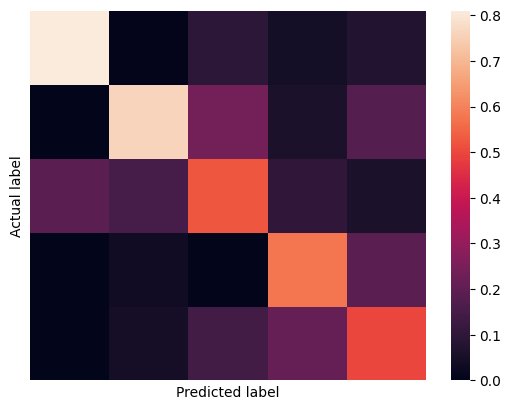

In [ ]:
display(eval_no_noise.get_all_metrics())
display(eval_no_noise.get_confusion_matrix(normalize='pred')[0])

### Some noise, full set

Up to one layer of noise, drawn from the full noise data set. Equal probability of using each noise class, or no noise at all. No attenuation.

In [ ]:
eval_some_noise = ModelEvaluation(
    noise_data=noise_files,
    max_layers=1,
    bernoulli=1.0 - 1.0/(len(noise_files.Location.unique())+1.0),
    random_state=314,
)

Extracting features...


  0%|          | 0/777 [00:00<?, ?it/s]

...done.
Computing optimal regularization parameter...
...done.
Optimal parameter: 0.013796459214299785
Best f1 score: 0.6252240074585671

Generating out of sample (oos) predictions...
...done.


,No weight,Session weight,Session and label weight
accuracy,0.614,0.645,0.530
balanced_accuracy,0.514,0.530,0.530
unweighted_f1,0.529,0.551,0.499
UAR,0.514,0.530,0.530
logloss,1.063,1.025,1.234


Predicted label,happy,frustrated,dysregulated,selftalk,delighted
Actual label,,,,,
happy,0.818182,0.004673,0.095238,0.044025,0.069307
frustrated,0.000000,0.761682,0.238095,0.059748,0.178218
dysregulated,0.181818,0.149533,0.523810,0.103774,0.059406
selftalk,0.000000,0.037383,0.000000,0.578616,0.193069
delighted,0.000000,0.046729,0.142857,0.213836,0.500000


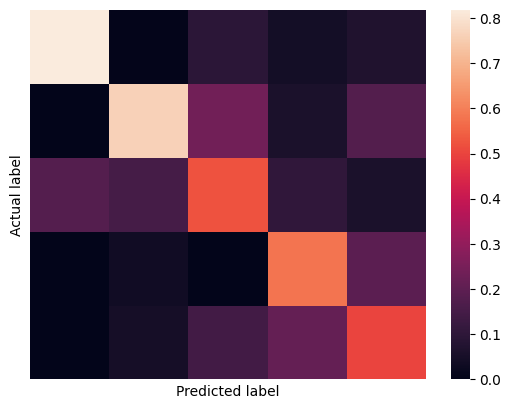

In [ ]:
display(eval_some_noise.get_all_metrics())
display(eval_some_noise.get_confusion_matrix(normalize='pred')[0])

We notice barely any difference compared to no noise, if not for the faintest fluctuation in `logloss`.

### Noise from one class. `bernoulli=.6`, `attenuation=.8`, `max_layers=3`.

Try with unlimited noise, but always drawn from the same class. Try different classes in separate iterations, always with the same parameters.

In [ ]:
eval_kitchen = ModelEvaluation(
    noise_data=noise_files.loc[noise_files.Location=='noise/DKITCHEN_16k/DKITCHEN'],
    bernoulli=.6,
    attenuation=.8,
    max_layers=3,
    random_state=314,
)

Extracting features...


  0%|          | 0/777 [00:00<?, ?it/s]

...done.
Computing optimal regularization parameter...
...done.
Optimal parameter: 0.011097216408010582
Best f1 score: 0.6251321842548594

Generating out of sample (oos) predictions...
...done.


,No weight,Session weight,Session and label weight
accuracy,0.602,0.635,0.500
balanced_accuracy,0.485,0.500,0.500
unweighted_f1,0.495,0.512,0.455
UAR,0.485,0.500,0.500
logloss,1.085,1.047,1.264


Predicted label,happy,frustrated,dysregulated,selftalk,delighted
Actual label,,,,,
happy,0.8,0.004808,0.055556,0.051360,0.087805
frustrated,0.0,0.769231,0.277778,0.057402,0.190244
dysregulated,0.2,0.153846,0.555556,0.105740,0.058537
selftalk,0.0,0.024038,0.000000,0.567976,0.185366
delighted,0.0,0.048077,0.111111,0.217523,0.478049


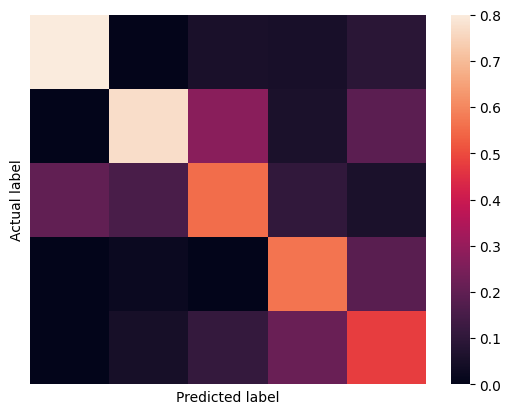

In [ ]:
display(eval_kitchen.get_all_metrics())
display(eval_kitchen.get_confusion_matrix(normalize='pred')[0])

In [ ]:
eval_living = ModelEvaluation(
    noise_data=noise_files.loc[noise_files.Location=='noise/DLIVING_16k/DLIVING'],
    bernoulli=.6,
    attenuation=.8,
    max_layers=3,
    random_state=314,
)

Extracting features...


  0%|          | 0/777 [00:00<?, ?it/s]

...done.
Computing optimal regularization parameter...
...done.
Optimal parameter: 0.006836292784814868
Best f1 score: 0.6253543961863687

Generating out of sample (oos) predictions...
...done.


,No weight,Session weight,Session and label weight
accuracy,0.561,0.602,0.435
balanced_accuracy,0.411,0.435,0.435
unweighted_f1,0.386,0.409,0.346
UAR,0.411,0.435,0.435
logloss,1.139,1.101,1.334


Predicted label,happy,frustrated,dysregulated,selftalk,delighted
Actual label,,,,,
happy,0.5,0.000000,0.000000,0.081744,0.087805
frustrated,0.0,0.765306,0.285714,0.068120,0.224390
dysregulated,0.5,0.158163,0.428571,0.125341,0.053659
selftalk,0.0,0.025510,0.000000,0.514986,0.180488
delighted,0.0,0.051020,0.285714,0.209809,0.453659


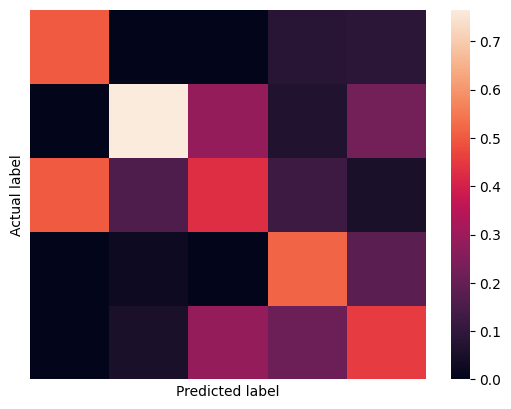

In [ ]:
display(eval_living.get_all_metrics())
display(eval_living.get_confusion_matrix(normalize='pred')[0])

In [24]:
eval_river = ModelEvaluation(
    noise_data=noise_files.loc[noise_files.Location=='noise/NRIVER_16k/NRIVER'],
    bernoulli=.6,
    attenuation=.8,
    max_layers=3,
    random_state=314,
)

Extracting features...


  0%|          | 0/777 [00:00<?, ?it/s]

...done.
Computing optimal regularization parameter...
...done.
Optimal parameter: 0.01423914031419386
Best f1 score: 0.6240105592550244

Generating out of sample (oos) predictions...
...done.


,No weight,Session weight,Session and label weight
accuracy,0.614,0.645,0.528
balanced_accuracy,0.511,0.528,0.528
unweighted_f1,0.525,0.548,0.496
UAR,0.511,0.528,0.528
logloss,1.061,1.022,1.232


Predicted label,happy,frustrated,dysregulated,selftalk,delighted
Actual label,,,,,
happy,0.809524,0.004673,0.095238,0.043887,0.074257
frustrated,0.000000,0.761682,0.238095,0.059561,0.178218
dysregulated,0.190476,0.149533,0.523810,0.103448,0.059406
selftalk,0.000000,0.037383,0.000000,0.579937,0.188119
delighted,0.000000,0.046729,0.142857,0.213166,0.500000


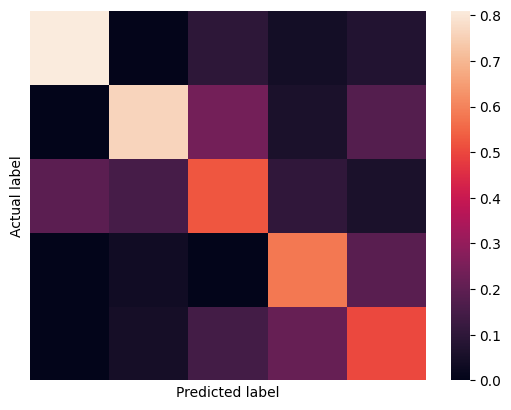

In [25]:
display(eval_river.get_all_metrics())
display(eval_river.get_confusion_matrix(normalize='pred')[0])

In [26]:
eval_resto = ModelEvaluation(
    noise_data=noise_files.loc[noise_files.Location=='noise/PRESTO_16k/PRESTO'],
    bernoulli=.6,
    attenuation=.8,
    max_layers=3,
    random_state=314,
)

Extracting features...


  0%|          | 0/777 [00:00<?, ?it/s]

...done.
Computing optimal regularization parameter...
...done.
Optimal parameter: 0.01203053861661638
Best f1 score: 0.6254880676452418

Generating out of sample (oos) predictions...
...done.


,No weight,Session weight,Session and label weight
accuracy,0.610,0.642,0.520
balanced_accuracy,0.501,0.520,0.520
unweighted_f1,0.516,0.540,0.486
UAR,0.501,0.520,0.520
logloss,1.077,1.039,1.253


Predicted label,happy,frustrated,dysregulated,selftalk,delighted
Actual label,,,,,
happy,0.833333,0.004739,0.052632,0.046296,0.082927
frustrated,0.000000,0.767773,0.263158,0.058642,0.180488
dysregulated,0.166667,0.151659,0.578947,0.104938,0.058537
selftalk,0.000000,0.028436,0.000000,0.574074,0.190244
delighted,0.000000,0.047393,0.105263,0.216049,0.487805


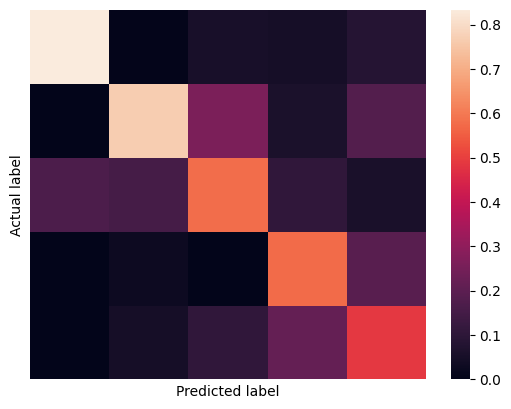

In [27]:
display(eval_resto.get_all_metrics())
display(eval_resto.get_confusion_matrix(normalize='pred')[0])

In [28]:
eval_square = ModelEvaluation(
    noise_data=noise_files.loc[noise_files.Location=='noise/SPSQUARE_16k/SPSQUARE'],
    bernoulli=.6,
    attenuation=.8,
    max_layers=3,
    random_state=314,
)

Extracting features...


  0%|          | 0/777 [00:00<?, ?it/s]

...done.
Computing optimal regularization parameter...
...done.
Optimal parameter: 0.013823495053320787
Best f1 score: 0.6252240074585671

Generating out of sample (oos) predictions...
...done.


,No weight,Session weight,Session and label weight
accuracy,0.614,0.645,0.530
balanced_accuracy,0.514,0.530,0.530
unweighted_f1,0.529,0.551,0.499
UAR,0.514,0.530,0.530
logloss,1.063,1.024,1.234


Predicted label,happy,frustrated,dysregulated,selftalk,delighted
Actual label,,,,,
happy,0.818182,0.004673,0.095238,0.044025,0.069307
frustrated,0.000000,0.761682,0.238095,0.059748,0.178218
dysregulated,0.181818,0.149533,0.523810,0.103774,0.059406
selftalk,0.000000,0.037383,0.000000,0.578616,0.193069
delighted,0.000000,0.046729,0.142857,0.213836,0.500000


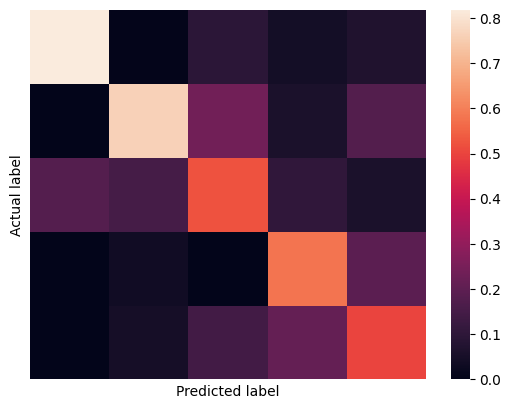

In [29]:
display(eval_square.get_all_metrics())
display(eval_square.get_confusion_matrix(normalize='pred')[0])